## Generative Adversarial Network
In this post, I show an example of using Deep Learning techniques with PyTorch to generate sequence. The example assume that you are familiar with the theory of the neural networks and Python.

I will use a the Generative Adversarial Networks a powerful class of neural networks with remarkable applications. They essentially consist of a system of two neural networks — the Generator and the Discriminator — dueling each other.

Given a set of target samples, the Generator tries to produce samples that can fool the Discriminator into believing they are real. The Discriminator tries to resolve real (target) samples from fake (generated) samples. Using this iterative training approach, we eventually end up with a Generator that is really good at generating samples similar to the target samples.

### Overview
- Requirements
- Load Python modules and dataset
- Create model
- Train Model
- Evaluate Model
- Save and load model weights to predict new cases

### 1- Requirements
- Python 3.6
- Pandas
- Numpy
- Matplotlib
- PyTorch
- Scikit Learn

### 2- Load Python modules and create input dataset

In [1]:
# import package
import pandas as pd
import numpy as np
import torch
import pickle

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

# set numpy seed for reproducibility
np.random.seed(seed=123)

In [2]:
# Create input dataset
x = [[39,40,41], [1,2,3], [4,5,6], [3,4,5], [9,10,11], [200,201,202], [123,124,125]]
y = [1,1,1,1,1,1,1]

### 3- Create model

In [3]:
# set model parameters
dim_fake_in = 100
dim_fake_out = 3
dim_real_in = 3
dim_real_out = 1

batch_size = 1
batch_no = int(len(x)/batch_size)
num_epoch = 1000
learning_rate = 0.001

In [4]:
# create Discriminator network architecture 
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(dim_real_in, 100),
            nn.Sigmoid(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, dim_real_out), 
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        return x
    
# create Discriminator network
D = discriminator()

In [5]:
# create Generator network architecture 
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(dim_fake_in, 100),
            nn.Sigmoid(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, dim_fake_out)
        )

    def forward(self, x):
        x = self.gen(x)
        return x
# create Generator network
G = generator()

In [6]:
# define loss
criterion = nn.BCELoss()

In [7]:
# define optimizer
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

In [8]:
# test generator
z = Variable(torch.randn(dim_fake_in).float())
fake_seq = G(z)
print (fake_seq)

tensor([ 0.0839,  0.1001, -0.0083], grad_fn=<AddBackward0>)


In [9]:
# test generator
z = Variable(torch.tensor(x[0]).float())
fake_seq = D(z)
print (fake_seq)

tensor([0.5205], grad_fn=<SigmoidBackward>)


### 4- Train Model

In [10]:
# Start training
epoch_d_loss = []
epoch_g_loss = []

for epoch in range(num_epoch):
        
    for i in range(len(x)):
        real_seq = Variable(torch.tensor(x[i]).float())
        real_label = Variable(torch.ones(y[i]).float())
        fake_label = Variable(torch.zeros(y[i]).float())
        
        # == train discriminator == #
        
        # compute loss of real_seq
        real_out = D(real_seq)
        d_loss_real = criterion(real_out, real_label)
        real_scores = real_out  # closer to 1 means better

        # compute loss of fake_seq
        z = Variable(torch.randn(dim_fake_in).float())
        fake_seq = G(z)
        fake_out = D(fake_seq)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out  # closer to 0 means better

        # backpropagate and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # == train generator ==#
        
        # compute loss of fake_seq
        z = Variable(torch.randn(dim_fake_in).float())
        fake_seq = G(z)
        output = D(fake_seq)
        g_loss = criterion(output, real_label)

        # backpropagate and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    epoch_g_loss.append(g_loss.item())
    epoch_d_loss.append(d_loss.item())
    
    if epoch % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
              'D real: {:.6f}, D fake: {:.6f}'.format(epoch, num_epoch, d_loss.item(), g_loss.item(),
                  real_scores.data.mean(), fake_scores.data.mean()))

Epoch [0/1000], d_loss: 1.121608, g_loss: 0.697682 D real: 0.655838, D fake: 0.503299
Epoch [100/1000], d_loss: 0.630348, g_loss: 1.164494 D real: 0.996802, D fake: 0.465886
Epoch [200/1000], d_loss: 0.390878, g_loss: 0.426950 D real: 0.999889, D fake: 0.323463
Epoch [300/1000], d_loss: 0.398556, g_loss: 0.845800 D real: 0.998243, D fake: 0.327530
Epoch [400/1000], d_loss: 0.578833, g_loss: 0.820986 D real: 0.998171, D fake: 0.438421
Epoch [500/1000], d_loss: 0.544549, g_loss: 1.118338 D real: 0.998400, D fake: 0.418967
Epoch [600/1000], d_loss: 0.541402, g_loss: 0.916234 D real: 0.999325, D fake: 0.417675
Epoch [700/1000], d_loss: 0.451911, g_loss: 0.758246 D real: 0.999665, D fake: 0.363376
Epoch [800/1000], d_loss: 0.529311, g_loss: 0.907580 D real: 0.999790, D fake: 0.410865
Epoch [900/1000], d_loss: 0.384821, g_loss: 1.143745 D real: 0.999965, D fake: 0.319404


### 5- Evaluate Model

In [11]:
# generate a sequence from random values with generator
print (G(Variable(torch.randn(dim_fake_in).float())))

# evaluate wrong seq with discriminator
print (D(Variable(torch.tensor([2,113,107]).float())))

# evaluate good seq with discriminator
D(Variable(torch.tensor([200,201,202]).float()))

tensor([0.8022, 1.8693, 2.8730], grad_fn=<AddBackward0>)
tensor([0.0001], grad_fn=<SigmoidBackward>)


tensor([1.0000], grad_fn=<SigmoidBackward>)

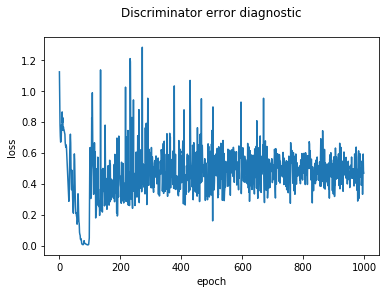

In [12]:
# show loss
plt.plot(epoch_d_loss)
plt.title('Discriminator error diagnostic\n')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

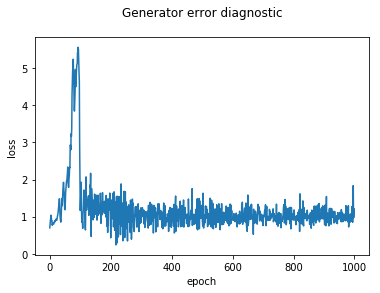

In [13]:
# show loss
plt.plot(epoch_g_loss)
plt.title('Generator error diagnostic\n')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### 6- Save and load model weights to predict new cases

In [14]:
# Save models
pickle.dump(D, open("../model/d_gan.p", "wb"))
pickle.dump(G, open("../model/g_gan.p", "wb"))

# load model
loaded_D = pickle.load(open("../model/d_gan.p", "rb"))
loaded_G = pickle.load(open("../model/g_gan.p", "rb"))

In [15]:
# generate a sequence from random values with generator
print (G(Variable(torch.randn(dim_fake_in).float())))

# generate a sequence from random values with loaded generator
print (loaded_G(Variable(torch.randn(dim_fake_in).float())))

tensor([2.7474, 4.0475, 5.1798], grad_fn=<AddBackward0>)
tensor([4.5212, 5.9894, 7.1078], grad_fn=<AddBackward0>)


In [16]:
# evaluate wrong seq with discriminator
print (D(Variable(torch.tensor([2,113,107]).float())))

# evaluate wrong seq with loaded discriminator
print (loaded_D(Variable(torch.tensor([2,113,107]).float())))

tensor([0.0001], grad_fn=<SigmoidBackward>)
tensor([0.0001], grad_fn=<SigmoidBackward>)


In [17]:
# evaluate good seq with discriminator
print (D(Variable(torch.tensor([200,201,202]).float())))

# evaluate good seq with loaded discriminator
print (loaded_D(Variable(torch.tensor([200,201,202]).float())))

tensor([1.0000], grad_fn=<SigmoidBackward>)
tensor([1.0000], grad_fn=<SigmoidBackward>)
